\newpage

# Future frequency of threshold exceedance under different climate change scenarios

In this chapter the future frequency of threshold exceendance is determined. This is done using forcings based on different climate change scenarios, the Shared Socioeconomic Pathways (SSPs). SSPs are a set of narratives that outline potential future scenarios for human society, focussing on the use of fossil fuels and the social and economic factors that influence the consumption of fossil fuel (ClimateData.ca, 2025). The five main SSPs (Meinshausen et al., 2020) are being considered: 

- **SSP1-1.9**: scenario of the 'sustainability' socio-economic family, reflects most closely a 1.5 °C target under the Paris agreement
- **SSP1-2.6**: 'sustainability' scenario as well, with a radiative forcing level of 2.6 W m−2 in 2100
- **SSP2-4.5**: scenario of the 'middle of the road' socio-economic family, which implies continuing with current development patterns, with a 4.5 W m−2 radiative forcing level by 2100
- **SSP3-7.0**: medium-high reference scenario in the 'regional rivalry' socio-economic family
- **SSP5-8.5**: high reference scenario in the 'fossil-fueled development' socio-economic family\
(Meinshausen et al., 2020; ClimateData.ca, 2025)

The future discharges are modelled with the HBV model using forcings from CMIP (Coupled Model Intercomparison Project) (Azote, 2025) as inputs. The nine parameters are calibrated in Chapter 4. 

## Historical Comparison

To be able to determine how well the model predicts discharge data using CMIP, it is important to compare the model output to observation data. This shows us the uncertainty of the model. The modelled discharge can be seen in figure 12, and the distribution of this discharge in figure 13.

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
camelsgb_id = "lamah_208082"

In [4]:
# historical data only available until 2014

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2014-01-01T00:00:00Z"

In [5]:
cmip_dataset = {
    "dataset": "EC-Earth3",
    "project": "CMIP6",
    "grid": "gr",
    "exp": "historical",
    "ensemble": "r6i1p1f1",
}

In [6]:
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

prepared_forcing_path_caravan_central = Path("/data/eurocsdms-data/forcing/lamah_208082/caravan")

# forcing_path_CMIP = Path.home() / "forcing" / camelsgb_id / "CMIP"  
forcing_path_CMIP = Path("/home/thirza/forcing/lamah_208082/CMIP")
forcing_path_CMIP.mkdir(exist_ok=True)

#prepared_forcing_path_ERA5_central = Path("/data/eurocsdms-data/forcing/camelsgb_73010/ERA5")

In [7]:
# # option two: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

In [8]:
# print(camelsgb_forcing)

In [9]:
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])

In [10]:
# # option one: generate forcing:
# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=camelsgb_forcing.shape,
# )

# # option two: load data that you or someone else generated previously
# #   this is needed because ERA5 forcing data is stored deep in a sub-directory
# load_location = prepared_forcing_path_caravan_central / "work" / "diagnostic" / "script" 
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(Path('/home/thirza/BEPproject/book/esmvaltool_output/ewcreppr6o7izt_20250320_150510/work/diagnostic/script'))

In [11]:
# print(CMIP_forcing)

In [12]:
#load calibration constants
#par_0 = np.loadtxt("/data/eurocsdms-data/calibration/calibration_" + camelsgb_id + ".csv", delimiter = ",")
# par_0 = np.loadtxt("/home/rhut/configFiles/calibration" + camelsgb_id + ".csv", delimiter = ",")
# par_0 = [1.46408246e-07, 8.68881909e-01, 1.02507886e+02, 2.20192834e+00,
#        1.05791079e+00, 1.84223360e-01, 1.15943798e+00, 1.59419229e+00,
#        5.97650513e-01]

par_0 = [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
       6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
       4.58706486e-01]

param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
# print(list(zip(param_names, np.round(par_0, decimals=3))))

In [13]:
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [14]:
model = ewatercycle.models.HBV(forcing=CMIP_forcing)

In [15]:
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)

In [16]:
model.initialize(config_file)

In [17]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [18]:
model.finalize()

In [19]:
model_output = pd.Series(data=Q_m, name="Modelled discharge", index=time)

In [20]:
# model_output.plot()
# ds_forcing["Q"].plot(label="Observed discharge")
# plt.legend()
# plt.ylabel("Discharge (mm/d)")

In [33]:
# plt.figure(figsize=(4, 3))

# catchment_area = ds_forcing["area"].values

# df = pd.DataFrame(model_output)
# model_data = df['Modelled discharge'] * catchment_area * 1000 / (24 * 60 * 60)
# (ds_forcing["Q"]* catchment_area * 1000 / (24 * 60 * 60)).plot(label="Observed discharge")

# plt.plot(df.index, model_data, label='Modelled discharge (m³/s)')

# plt.xlabel('Date')
# plt.ylabel('Discharge (m³/s)')
# plt.title('Modelled historical discharge')
# plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
# plt.legend()

# # plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)

# plt.text(0.5, -0.4, "Figure 12: Historical discharge using CMIP", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes);
# plt.show()

In [22]:
# import scipy.stats as stats
# import math
# from scipy.optimize import curve_fit, fsolve
# plt.figure(figsize=(4, 3))
# # Sort data from high to low
# sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend


# def power_law(x, a, b):
#     return a * x ** b

# def calculate_return_periods(sorted_model_data):
#     n = len(sorted_model_data)
#     rank = np.arange(1, n + 1)
#     return_periods_days = (n + 1) / rank
#     return_periods_years = return_periods_days / 365.25
    
#     # Alleen de data voor returnperioden >= 0 behouden
#     return_periods_years_subset = return_periods_years[return_periods_years >= 0]
#     sorted_data_subset = sorted_model_data[return_periods_years >= 0]

#     # Fit de power law functie
#     params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=1000)
#     a_opt, b_opt = params

#     # Maak een fit voor de return period
#     x_fit = np.logspace(np.log(min(sorted_model_data)+1e-1), np.log(max(return_periods_years_subset)), 1000)
#     y_fit = power_law(x_fit, a_opt, b_opt)

#     return x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset

# x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset = calculate_return_periods(sorted_model_data)

# def find_x_for_y(y_target, a, b):
#     return (y_target / a) ** (1 / b)
# y_target = 530
# x_value = find_x_for_y(y_target, a_opt, b_opt)
# # print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

# plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed')
# plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed')
# plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')  
# plt.text(0.001, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

# y_target = 534
# x_value = find_x_for_y(y_target, a_opt, b_opt)
# # print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

# plt.plot(x_fit, y_fit, color='blue', label=f'Fit Future Climate')

# plt.xscale('log')
# plt.scatter(return_periods_years_subset, sorted_data_subset, label='Model', color='red')
# plt.legend()
# plt.xlabel('Return period (years)')
# plt.ylabel('Discharge ($m^3/s$)')
# plt.title('Modelled Discharge Extrapolation')
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# plt.text(0.6, -0.3, "Figure 13: Historical modelled discharge distribution and extrapolation using CMIP ", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes);
# plt.show()

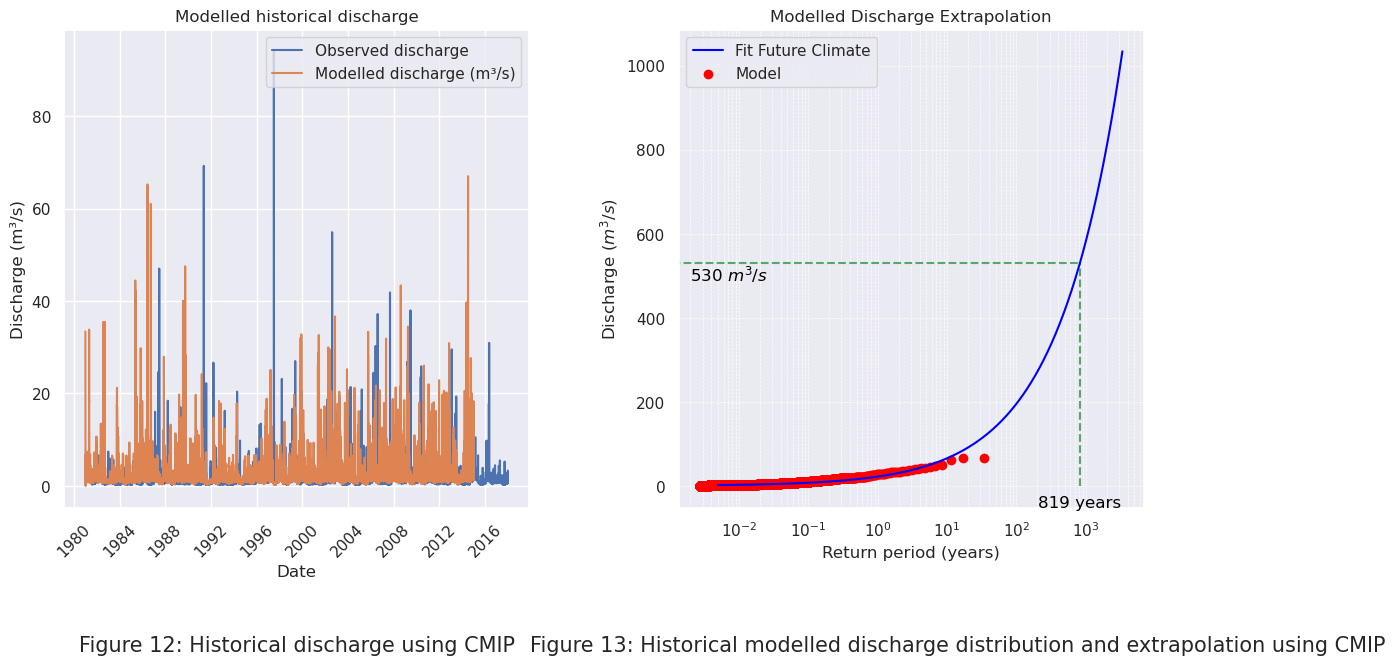

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
from scipy.optimize import curve_fit, fsolve

time_index = pd.to_datetime(ds_forcing['time'].values)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# ---- First subplot: Modelled historical discharge ----
catchment_area = ds_forcing["area"].values
df = pd.DataFrame(model_output)
model_data = df['Modelled discharge'] * catchment_area * 1000 / (24 * 60 * 60)
axes[0].plot(time_index, ds_forcing["Q"] * catchment_area * 1000 / (24 * 60 * 60), label="Observed discharge")
axes[0].plot(df.index, model_data, label='Modelled discharge (m³/s)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Discharge (m³/s)')
axes[0].set_title('Modelled historical discharge')
axes[0].tick_params(axis='x', rotation=45)  # Rotate the dates for better readability
axes[0].legend()
axes[0].text(0.5, -0.3, "Figure 12: Historical discharge using CMIP", 
             ha="center", fontsize=15, transform=axes[0].transAxes)



sorted_model_data = np.sort(model_data)[::-1]

def power_law(x, a, b):
    return a * x ** b

def calculate_return_periods(sorted_model_data):
    n = len(sorted_model_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25
    
    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_model_data[return_periods_years >= 0]

    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=1000)
    a_opt, b_opt = params

    x_fit = np.logspace(np.log(min(sorted_model_data)+1e-1), np.log(max(return_periods_years_subset)), 1000)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset

x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset = calculate_return_periods(sorted_model_data)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)

y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)

axes[1].hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed')
axes[1].vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed')
axes[1].text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')  
axes[1].text(0.002, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)

axes[1].plot(x_fit, y_fit, color='blue', label=f'Fit Future Climate')
axes[1].scatter(return_periods_years_subset, sorted_data_subset, label='Model', color='red')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].set_xlabel('Return period (years)')
axes[1].set_ylabel('Discharge ($m^3/s$)')
axes[1].set_title('Modelled Discharge Extrapolation')
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)
axes[1].text(0.6, -0.3, "Figure 13: Historical modelled discharge distribution and extrapolation using CMIP", 
             ha="center", fontsize=15, transform=axes[1].transAxes)

# Adjust layout
plt.tight_layout()
plt.show()


In figure 13 it can be seen that the mean treshold value of 530 m3/s has a return period of 819 years. The extrapolated return period of the observed discharge determined in Chapter 3 amounted to 641 years. This means that the modelled and observed data result in a 27.7% difference. Therefore, with determining the return periods with different climate change scenarios, a model uncertainty of 27.7% is taken into account.

## Future Scenarios

Next, the future discharges for different climate change scenarios can be modelled using forcings from CMIP. The future discharge is projected for a period of 40 years, from 2060 to 2100. The observation data is available for a period of about 40 years, so to be able to make a good comparison between the historical observation data and the future projected data, it is imported to use periods of equal lengths . This ensures that the comparison reflects differences in discharge rather than differences in trends caused by unequeal time spans. It eliminates the influence of longer-term variations or trends that may occur over extended periods. Furthermore, the future discharge is projected for the period from 2060 to 2100. A period at the end of the century is used rather than the upcoming 40 years, since climate change projections are expected to get more extreme. By modeling future discharge under the most extreme expected climate scenarios, recommendations can be provided for the development of infrastructure designed for long-term resilience and protection.

In figure 14 the future modelled discharges are plotted for the differenct climate change scenarios. In figure 15 the distribution and extrapolation to the threshold values can be seen.

In [24]:
# from PIL import Image as PILImage
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# fig, axs = plt.subplots(3, 2, figsize=(12, 12))
# axs = axs.flatten()

# img1 = mpimg.imread('grafiek119discharge.png')  
# img2 = mpimg.imread('grafiek126discharge.png')
# img3 = mpimg.imread('grafiek245discharge.png')  
# img4 = mpimg.imread('grafiek370discharge.png')
# img5 = mpimg.imread('grafiek585discharge.png')  


# # Voeg de afbeeldingen toe aan de subplots
# images = [img1, img2, img3, img4, img5]
# for i in range(5):
#     axs[i].imshow(images[i])
#     axs[i].axis('off')


# axs[5].axis('off') 

# fig.suptitle('Modelled Future Discharges', fontsize=13)
# fig.text(0, -0.25, "Figure 15: Modelled discharge for different climate change scenarios", 
#          ha="center", fontsize=15, transform=plt.gca().transAxes)
# plt.tight_layout()
# plt.show()

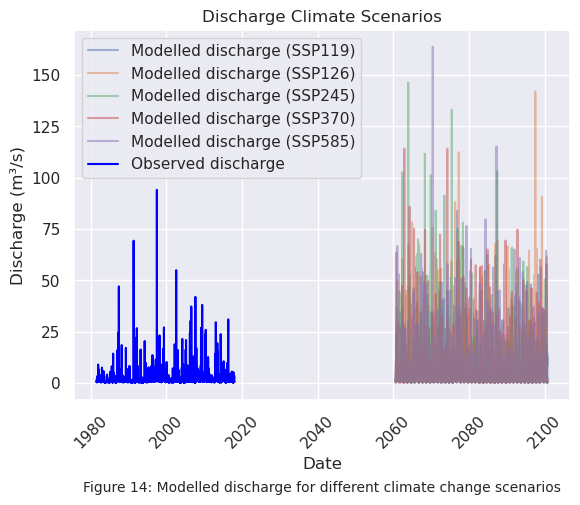

In [25]:
import pickle
import matplotlib.pyplot as plt

# Functie om de opgeslagen gegevens in te lezen
def load_data(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

# Pad naar de bestanden
file_paths = [
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario119_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario126_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario245_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario370_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario585_data.pkl",
]
for file_path in file_paths:

    input_data = load_data(file_path)

    model_data = input_data['model_data']
    df = input_data['df']
    ds_forcing = input_data['ds_forcing']
    scenario_name = input_data['scenario_name']
    
    plt.plot(df.index, model_data, label=f'Modelled discharge ({scenario_name})', alpha=0.5)
catchment_area = ds_forcing["area"].values
(ds_forcing["Q"]* catchment_area * 1000 / (24 * 60 * 60)).plot(label="Observed discharge", color='blue')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Discharge Climate Scenarios')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()
plt.text(0.5, -0.25, "Figure 14: Modelled discharge for different climate change scenarios", 
         ha="center", fontsize=10, transform=plt.gca().transAxes)
# plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/grafiek119discharge.png", dpi=300)
plt.show()

In [26]:
# from PIL import Image as PILImage
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# fig, axs = plt.subplots(3, 2, figsize=(12, 12))
# axs = axs.flatten()

# img1 = mpimg.imread('grafiek119distribution.png')  
# img2 = mpimg.imread('grafiek126distribution.png')
# img3 = mpimg.imread('grafiek245distribution.png')  
# img4 = mpimg.imread('grafiek370distribution.png')
# img5 = mpimg.imread('grafiek585distribution.png')  


# # Voeg de afbeeldingen toe aan de subplots
# images = [img1, img2, img3, img4, img5]
# for i in range(5):
#     axs[i].imshow(images[i])
#     axs[i].axis('off')


# axs[5].axis('off') 

# fig.suptitle('Modelled Future Distribution and Extrapolation', fontsize=13)
# fig.text(0, -0.25, "Figure 16: Modelled discharge distribution and extrapolation for different climate change scenarios", 
#          ha="center", fontsize=15, transform=plt.gca().transAxes)
# plt.tight_layout()
# plt.show()

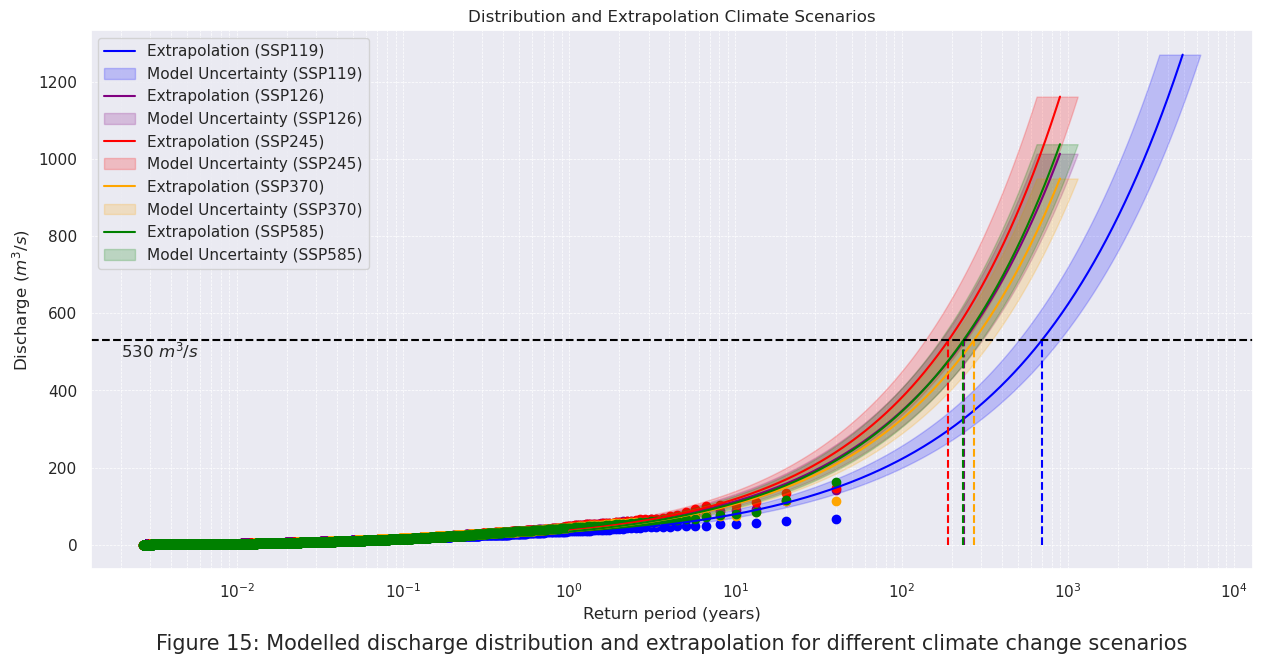

In [27]:
colors = ['blue', 'purple', 'red', 'orange', 'green']
plt.figure(figsize=(15, 7))

for idx, file_path in enumerate(file_paths):
    # Lees de data in
    input_data = load_data(file_path)
    
    
    return_periods_years_subset = input_data['return_periods_years_subset']
    sorted_data_subset = input_data['sorted_data_subset']
    x_fit = input_data['x_fit']
    y_fit = input_data['y_fit']
    x_lower_bound = input_data['x_lower_bound']
    x_upper_bound = input_data['x_upper_bound']
    scenario_name = input_data.get('scenario_name', f"Scenario {idx + 1}") 
    
    color = colors[idx % len(colors)]

    plt.scatter(return_periods_years_subset, sorted_data_subset, color=color)
    plt.plot(x_fit, y_fit, label=f"Extrapolation ({scenario_name})", color=color)
    plt.fill_betweenx(y_fit, x_lower_bound, x_upper_bound, alpha=0.2, label=f"Model Uncertainty ({scenario_name})", color=color)


    y_target = 530
    x_value = find_x_for_y(y_target, input_data['a_opt'], input_data['b_opt'])

    
    plt.vlines(x_value, ymin=0, ymax=y_target, colors=color, linestyles='dashed')
    # plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color=color)
    # print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")
plt.axhline(y_target, linestyle='dashed', color='black')
plt.text(0.002, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12)    
plt.xscale('log')
# plt.yscale('log', nonpositive='clip')  # Als je de y-as logaritmisch wilt maken
plt.xlabel('Return period (years)')
plt.ylabel('Discharge ($m^3/s$)')
plt.title('Distribution and Extrapolation Climate Scenarios')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.text(0.5, -0.15, "Figure 15: Modelled discharge distribution and extrapolation for different climate change scenarios", 
         ha="center", fontsize=15, transform=plt.gca().transAxes)
plt.show()

## Conclusion

From figure 15, it can be concluded that the future return periods for a discharge of 530 m3/s considering the different climate change scenarios are:

- **SSP119:** 697 years, with a model uncertainty ranging from 504 to 890 years
- **SSP126:** 238 years, with a model uncertainty ranging from 172 to 292 years
- **SSP245:** 191 years, with a model uncertainty ranging from 138 to 234 years
- **SSP370:** 272 years, with a model uncertainty ranging from 197 to 334 years
- **SSP585:** 235 years, with a model uncertainty ranging from 170 to 288 years
